In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             precision_recall_curve, auc, roc_curve, f1_score,
                             precision_score, recall_score, matthews_corrcoef)

# Imbalanced data handling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

# Models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

In [8]:
df = pd.read_csv("data/PS_20174392719_1491204439457_log.csv")
print(f"\nDataset Shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nData Info:")
print(df.info())
print(f"\nMissing Values:")
print(df.isnull().sum())
print(f"\nBasic Statistics:")
print(df.describe())



Dataset Shape: (6362620, 11)

First few rows:
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeInd


Fraud Distribution:
isFraud
0    6354407
1       8213
Name: count, dtype: int64

Percentage:
isFraud
0    99.870918
1     0.129082
Name: proportion, dtype: float64

Imbalance Ratio: 773.70:1

Transaction Types Distribution:
type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

Fraud by Transaction Type:
          Fraud_Count  Total_Count  Fraud_Rate
type                                          
CASH_IN             0      1399284    0.000000
CASH_OUT         4116      2237500    0.001840
DEBIT               0        41432    0.000000
PAYMENT             0      2151495    0.000000
TRANSFER         4097       532909    0.007688


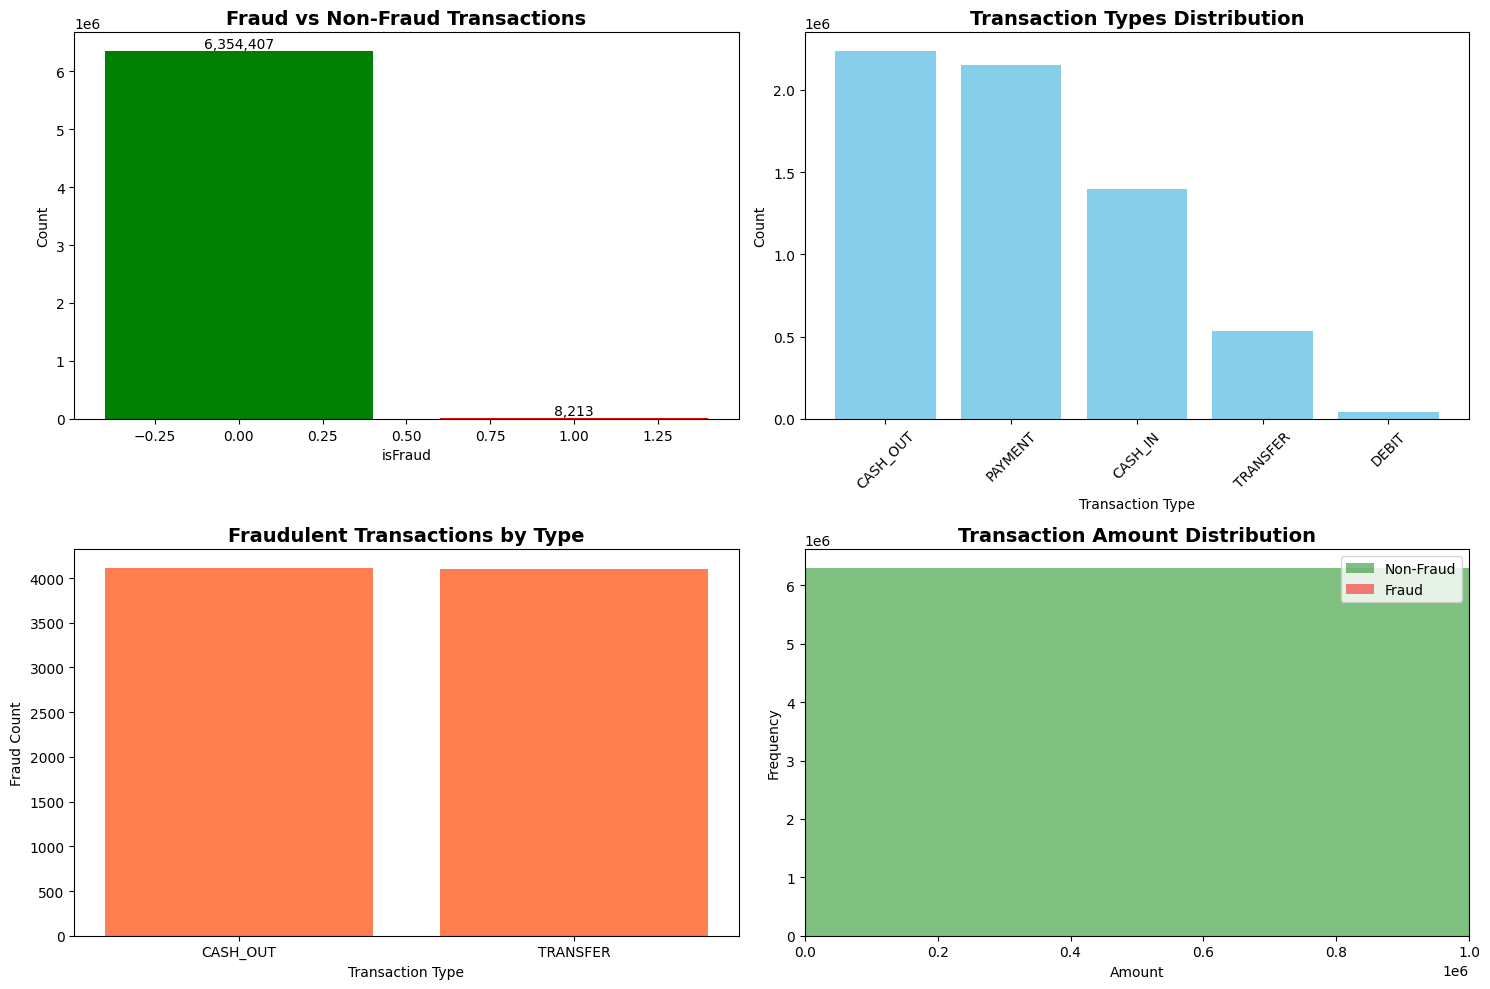

In [9]:
# Check fraud distribution
fraud_dist = df['isFraud'].value_counts()
print(f"\nFraud Distribution:")
print(fraud_dist)
print(f"\nPercentage:")
print(df['isFraud'].value_counts(normalize=True) * 100)

imbalance_ratio = fraud_dist[0] / fraud_dist[1]
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}:1")

# Transaction types distribution
print(f"\nTransaction Types Distribution:")
print(df['type'].value_counts())

# Fraud by transaction type
print(f"\nFraud by Transaction Type:")
fraud_by_type = df.groupby('type')['isFraud'].agg(['sum', 'count', 'mean'])
fraud_by_type.columns = ['Fraud_Count', 'Total_Count', 'Fraud_Rate']
print(fraud_by_type)

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Fraud distribution
axes[0, 0].bar(fraud_dist.index, fraud_dist.values, color=['green', 'red'])
axes[0, 0].set_title('Fraud vs Non-Fraud Transactions', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('isFraud')
axes[0, 0].set_ylabel('Count')
for i, v in enumerate(fraud_dist.values):
    axes[0, 0].text(i, v, f'{v:,}', ha='center', va='bottom')

# Plot 2: Transaction types
type_counts = df['type'].value_counts()
axes[0, 1].bar(type_counts.index, type_counts.values, color='skyblue')
axes[0, 1].set_title('Transaction Types Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Transaction Type')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=45)

# Plot 3: Fraud by type
fraud_by_type_plot = df[df['isFraud']==1]['type'].value_counts()
axes[1, 0].bar(fraud_by_type_plot.index, fraud_by_type_plot.values, color='coral')
axes[1, 0].set_title('Fraudulent Transactions by Type', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Transaction Type')
axes[1, 0].set_ylabel('Fraud Count')

# Plot 4: Amount distribution
axes[1, 1].hist(df[df['isFraud']==0]['amount'], bins=50, alpha=0.5, label='Non-Fraud', color='green')
axes[1, 1].hist(df[df['isFraud']==1]['amount'], bins=50, alpha=0.5, label='Fraud', color='red')
axes[1, 1].set_title('Transaction Amount Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Amount')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].set_xlim(0, 1000000)

plt.tight_layout()
plt.show()


In [10]:
# Create a copy
df_engineered = df.copy()

# 4.1 Balance Features
df_engineered['balanceOrig_diff'] = df_engineered['oldbalanceOrg'] - df_engineered['newbalanceOrig']
df_engineered['balanceDest_diff'] = df_engineered['newbalanceDest'] - df_engineered['oldbalanceDest']

# 4.2 Error in balances (should match amount for legitimate transactions)
df_engineered['errorBalanceOrig'] = df_engineered['balanceOrig_diff'] - df_engineered['amount']
df_engineered['errorBalanceDest'] = df_engineered['balanceDest_diff'] - df_engineered['amount']

# 4.3 Transaction to balance ratio
df_engineered['amountToBalanceOrig'] = df_engineered['amount'] / (df_engineered['oldbalanceOrg'] + 1)
df_engineered['amountToBalanceDest'] = df_engineered['amount'] / (df_engineered['oldbalanceDest'] + 1)

# 4.4 Zero balance flags
df_engineered['origBalanceZero'] = (df_engineered['oldbalanceOrg'] == 0).astype(int)
df_engineered['destBalanceZero'] = (df_engineered['oldbalanceDest'] == 0).astype(int)
df_engineered['origBalanceZeroAfter'] = (df_engineered['newbalanceOrig'] == 0).astype(int)

# 4.5 Merchant flags (destinations starting with M)
df_engineered['isMerchantDest'] = df_engineered['nameDest'].str.startswith('M').astype(int)
df_engineered['isMerchantOrig'] = df_engineered['nameOrig'].str.startswith('M').astype(int)

# 4.6 Hour of day features
df_engineered['hour'] = df_engineered['step'] % 24
df_engineered['day'] = df_engineered['step'] // 24

# 4.7 Encode transaction type
le = LabelEncoder()
df_engineered['type_encoded'] = le.fit_transform(df_engineered['type'])

# 4.8 High-risk transaction flags
df_engineered['isTransferOrCashout'] = df_engineered['type'].isin(['TRANSFER', 'CASH_OUT']).astype(int)
df_engineered['highAmount'] = (df_engineered['amount'] > 200000).astype(int)

print(f"\nNew features created: {df_engineered.shape[1] - df.shape[1]}")
print(f"\nFeature list:")
print(df_engineered.columns.tolist())


New features created: 16

Feature list:
['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'balanceOrig_diff', 'balanceDest_diff', 'errorBalanceOrig', 'errorBalanceDest', 'amountToBalanceOrig', 'amountToBalanceDest', 'origBalanceZero', 'destBalanceZero', 'origBalanceZeroAfter', 'isMerchantDest', 'isMerchantOrig', 'hour', 'day', 'type_encoded', 'isTransferOrCashout', 'highAmount']


In [11]:
# Target variable
df['fraud_label'] = df['isFraud']

# Drop original isFraud column
df = df.drop(columns=['isFraud'])

In [13]:
# 5. PREPARE DATA FOR MODELING
# ============================================================================
print("\n" + "="*80)
print("DATA PREPARATION")
print("="*80)

# Select features for modeling
features_to_drop = ['nameOrig', 'nameDest', 'isFlaggedFraud', 'isFraud', 'type']
X = df_engineered.drop(columns=features_to_drop)
y = df_engineered['isFraud']

print(f"\nFeatures used for modeling: {X.shape[1]}")
print(f"Feature names: {X.columns.tolist()}")

# CRITICAL: Handle missing values in both X and y
print(f"\nChecking for missing values...")
print(f"Missing values in X: {X.isnull().sum().sum()}")
print(f"Missing values in y: {y.isnull().sum()}")

# Handle any infinite values in X
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

# Handle missing values in y (target variable)
if y.isnull().sum() > 0:
    print(f"\nWARNING: Found {y.isnull().sum()} missing values in target variable!")
    print("Removing rows with missing target values...")

    # Remove rows where y is NaN
    valid_indices = ~y.isnull()
    X = X[valid_indices]
    y = y[valid_indices]

    print(f"Cleaned dataset shape: {X.shape}")
    print(f"Remaining fraud cases: {y.sum()}")

# Verify no NaN values remain
assert X.isnull().sum().sum() == 0, "X still contains NaN values!"
assert y.isnull().sum() == 0, "y still contains NaN values!"
print("\nData is clean and ready for modeling")

# Split data: 60% train, 20% validation, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"\nData Split:")
print(f"Train: {X_train.shape[0]:,} samples ({y_train.sum():,} frauds)")
print(f"Validation: {X_val.shape[0]:,} samples ({y_val.sum():,} frauds)")
print(f"Test: {X_test.shape[0]:,} samples ({y_test.sum():,} frauds)")

# Scale features (important for some models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


DATA PREPARATION

Features used for modeling: 22
Feature names: ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'balanceOrig_diff', 'balanceDest_diff', 'errorBalanceOrig', 'errorBalanceDest', 'amountToBalanceOrig', 'amountToBalanceDest', 'origBalanceZero', 'destBalanceZero', 'origBalanceZeroAfter', 'isMerchantDest', 'isMerchantOrig', 'hour', 'day', 'type_encoded', 'isTransferOrCashout', 'highAmount']

Checking for missing values...
Missing values in X: 0
Missing values in y: 0

Data is clean and ready for modeling

Data Split:
Train: 3,817,572 samples (4,928 frauds)
Validation: 1,272,524 samples (1,642 frauds)
Test: 1,272,524 samples (1,643 frauds)


In [14]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,fraud_label
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,0,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,0,1
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,0,1
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,0,1
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,0,1
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,0,1


In [15]:
# 6. HANDLE IMBALANCED DATA
# ============================================================================
print("\n" + "="*80)
print("HANDLING IMBALANCED DATA")
print("="*80)

# Strategy: Hybrid approach (SMOTE + Undersampling)
# This balances performance and training time

print("\nApplying SMOTE + RandomUnderSampler...")

# First oversample minority class to 30% of majority
smote = SMOTE(sampling_strategy=0.3, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Then undersample majority to 70% ratio
rus = RandomUnderSampler(sampling_strategy=0.7, random_state=42)
X_train_balanced, y_train_balanced = rus.fit_resample(X_train_smote, y_train_smote)

print(f"\nOriginal training set: {len(y_train):,}")
print(f"After SMOTE: {len(y_train_smote):,}")
print(f"After Undersampling: {len(y_train_balanced):,}")
print(f"\nBalanced class distribution:")
print(pd.Series(y_train_balanced).value_counts())


HANDLING IMBALANCED DATA

Applying SMOTE + RandomUnderSampler...

Original training set: 3,817,572
After SMOTE: 4,956,437
After Undersampling: 2,777,783

Balanced class distribution:
isFraud
0    1633990
1    1143793
Name: count, dtype: int64


In [16]:
# 7. MODEL TRAINING
# ============================================================================
print("\n" + "="*80)
print("MODEL TRAINING")
print("="*80)

# Define evaluation function
def evaluate_model(model, X_val, y_val, X_test, y_test, model_name):
    """Comprehensive model evaluation"""
    print(f"\n{'='*80}")
    print(f"{model_name.upper()} - EVALUATION")
    print(f"{'='*80}")

    # Validation predictions
    y_val_pred = model.predict(X_val)
    y_val_proba = model.predict_proba(X_val)[:, 1]

    # Test predictions
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]

    # Validation metrics
    print(f"\n{'-'*40}")
    print("VALIDATION SET METRICS")
    print(f"{'-'*40}")
    print(classification_report(y_val, y_val_pred))

    val_roc_auc = roc_auc_score(y_val, y_val_proba)
    precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_proba)
    val_pr_auc = auc(recall_val, precision_val)
    val_f1 = f1_score(y_val, y_val_pred)
    val_mcc = matthews_corrcoef(y_val, y_val_pred)

    print(f"ROC-AUC: {val_roc_auc:.4f}")
    print(f"PR-AUC: {val_pr_auc:.4f}")
    print(f"F1-Score: {val_f1:.4f}")
    print(f"MCC: {val_mcc:.4f}")

    # Test metrics
    print(f"\n{'-'*40}")
    print("TEST SET METRICS")
    print(f"{'-'*40}")
    print(classification_report(y_test, y_test_pred))

    test_roc_auc = roc_auc_score(y_test, y_test_proba)
    precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_proba)
    test_pr_auc = auc(recall_test, precision_test)
    test_f1 = f1_score(y_test, y_test_pred)
    test_mcc = matthews_corrcoef(y_test, y_test_pred)

    print(f"ROC-AUC: {test_roc_auc:.4f}")
    print(f"PR-AUC: {test_pr_auc:.4f}")
    print(f"F1-Score: {test_f1:.4f}")
    print(f"MCC: {test_mcc:.4f}")

    # Confusion Matrix
    print(f"\nConfusion Matrix (Test Set):")
    cm = confusion_matrix(y_test, y_test_pred)
    print(cm)
    print(f"\nTrue Negatives: {cm[0,0]:,}")
    print(f"False Positives: {cm[0,1]:,}")
    print(f"False Negatives: {cm[1,0]:,}")
    print(f"True Positives: {cm[1,1]:,}")

    # Calculate financial metrics
    fraud_detected = cm[1,1]
    fraud_missed = cm[1,0]
    detection_rate = fraud_detected / (fraud_detected + fraud_missed) * 100
    print(f"\nFraud Detection Rate: {detection_rate:.2f}%")

    return {
        'model': model,
        'val_roc_auc': val_roc_auc,
        'val_pr_auc': val_pr_auc,
        'val_f1': val_f1,
        'test_roc_auc': test_roc_auc,
        'test_pr_auc': test_pr_auc,
        'test_f1': test_f1,
        'test_mcc': test_mcc,
        'y_test_proba': y_test_proba
    }

# 7.1 XGBoost Model (Usually best for fraud detection)
print("\n\nTraining XGBoost Model...")
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

xgb_model.fit(X_train_balanced, y_train_balanced)
xgb_results = evaluate_model(xgb_model, X_val_scaled, y_val, X_test_scaled, y_test, "XGBoost")

# 7.2 LightGBM Model (Faster, often comparable performance)
print("\n\nTraining LightGBM Model...")
lgbm_model = LGBMClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_samples=20,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

lgbm_model.fit(X_train_balanced, y_train_balanced)
lgbm_results = evaluate_model(lgbm_model, X_val_scaled, y_val, X_test_scaled, y_test, "LightGBM")

# 7.3 Random Forest Model
print("\n\nTraining Random Forest Model...")
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_balanced, y_train_balanced)
rf_results = evaluate_model(rf_model, X_val_scaled, y_val, X_test_scaled, y_test, "Random Forest")



MODEL TRAINING


Training XGBoost Model...

XGBOOST - EVALUATION

----------------------------------------
VALIDATION SET METRICS
----------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270882
           1       0.98      1.00      0.99      1642

    accuracy                           1.00   1272524
   macro avg       0.99      1.00      1.00   1272524
weighted avg       1.00      1.00      1.00   1272524

ROC-AUC: 1.0000
PR-AUC: 0.9996
F1-Score: 0.9921
MCC: 0.9922

----------------------------------------
TEST SET METRICS
----------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.99      1.00      0.99      1643

    accuracy                           1.00   1272524
   macro avg       0.99      1.00      1.00   1272524
weighted avg       1.00      1.00      1.00   1272524

ROC-AUC: 0.999


MODEL COMPARISON SUMMARY

         Model  Test_ROC_AUC  Test_PR_AUC  Test_F1  Test_MCC
      XGBoost      0.999738     0.998409 0.991831  0.991836
     LightGBM      0.999770     0.998679 0.995747  0.995743
Random Forest      0.999948     0.998660 0.989436  0.989455

🏆 BEST MODEL: LightGBM (based on PR-AUC)

FEATURE IMPORTANCE (XGBoost)

Top 15 Most Important Features:
             Feature  Importance
    balanceOrig_diff    0.499950
origBalanceZeroAfter    0.254143
    errorBalanceOrig    0.124491
      newbalanceOrig    0.035721
 amountToBalanceOrig    0.023354
              amount    0.018904
 isTransferOrCashout    0.010604
        type_encoded    0.009060
      newbalanceDest    0.004960
      isMerchantDest    0.003767
     origBalanceZero    0.002658
                hour    0.002236
     destBalanceZero    0.001997
    balanceDest_diff    0.001829
    errorBalanceDest    0.001531


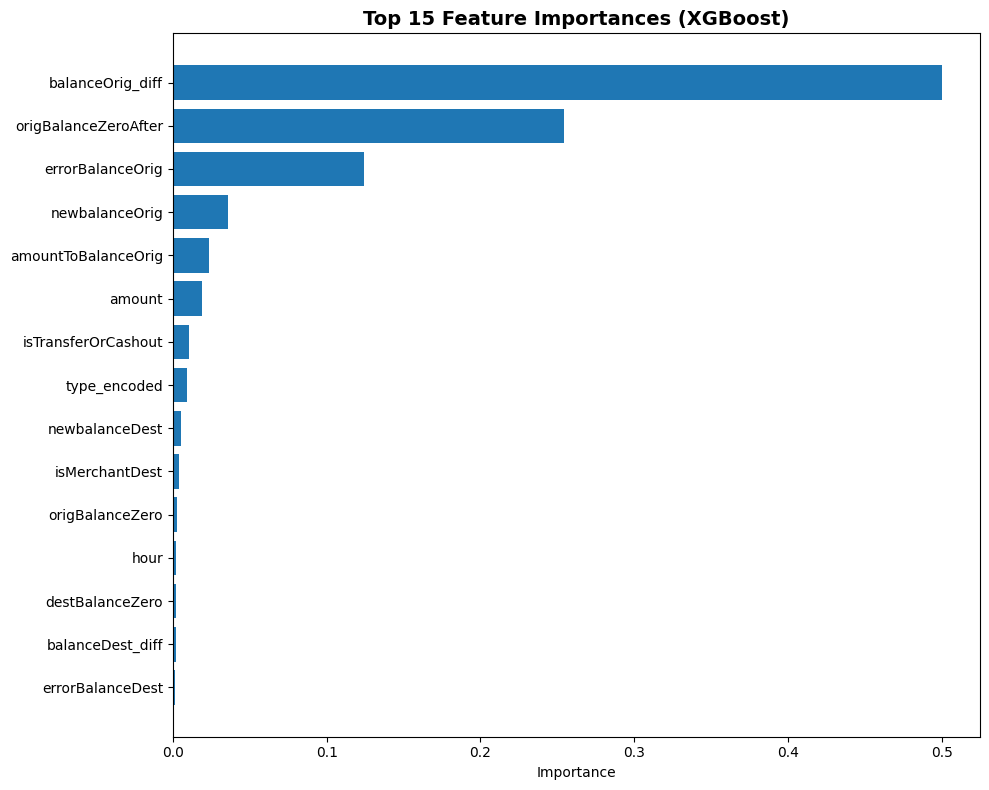

In [17]:
# 8. MODEL COMPARISON

print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)

comparison = pd.DataFrame({
    'Model': ['XGBoost', 'LightGBM', 'Random Forest'],
    'Test_ROC_AUC': [xgb_results['test_roc_auc'], lgbm_results['test_roc_auc'], rf_results['test_roc_auc']],
    'Test_PR_AUC': [xgb_results['test_pr_auc'], lgbm_results['test_pr_auc'], rf_results['test_pr_auc']],
    'Test_F1': [xgb_results['test_f1'], lgbm_results['test_f1'], rf_results['test_f1']],
    'Test_MCC': [xgb_results['test_mcc'], lgbm_results['test_mcc'], rf_results['test_mcc']]
})

print("\n", comparison.to_string(index=False))

best_model_idx = comparison['Test_PR_AUC'].idxmax()
best_model_name = comparison.loc[best_model_idx, 'Model']
print(f"\n🏆 BEST MODEL: {best_model_name} (based on PR-AUC)")

# 9. FEATURE IMPORTANCE
# ============================================================================
print("\n" + "="*80)
print("FEATURE IMPORTANCE (XGBoost)")
print("="*80)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 15 Most Important Features:")
print(feature_importance.head(15).to_string(index=False))

# Plot feature importance
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['Importance'])
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances (XGBoost)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

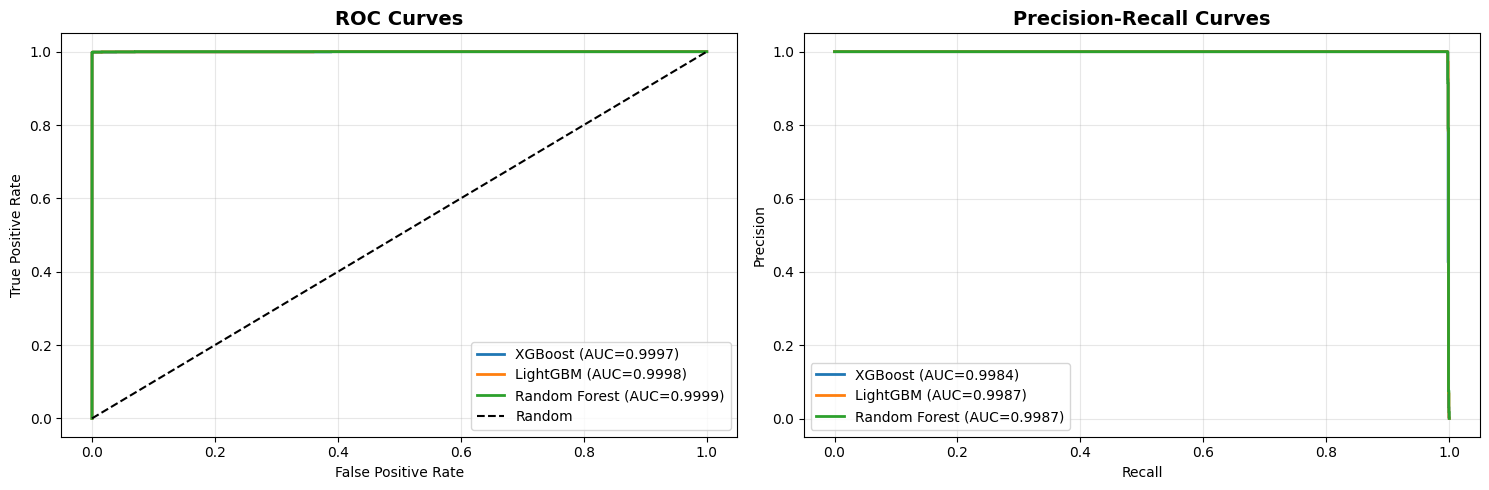

In [18]:
# 10. ROC AND PR CURVES
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ROC Curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_results['y_test_proba'])
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, lgbm_results['y_test_proba'])
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_results['y_test_proba'])

axes[0].plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC={xgb_results['test_roc_auc']:.4f})", linewidth=2)
axes[0].plot(fpr_lgbm, tpr_lgbm, label=f"LightGBM (AUC={lgbm_results['test_roc_auc']:.4f})", linewidth=2)
axes[0].plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC={rf_results['test_roc_auc']:.4f})", linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Precision-Recall Curve
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, xgb_results['y_test_proba'])
precision_lgbm, recall_lgbm, _ = precision_recall_curve(y_test, lgbm_results['y_test_proba'])
precision_rf, recall_rf, _ = precision_recall_curve(y_test, rf_results['y_test_proba'])

axes[1].plot(recall_xgb, precision_xgb, label=f"XGBoost (AUC={xgb_results['test_pr_auc']:.4f})", linewidth=2)
axes[1].plot(recall_lgbm, precision_lgbm, label=f"LightGBM (AUC={lgbm_results['test_pr_auc']:.4f})", linewidth=2)
axes[1].plot(recall_rf, precision_rf, label=f"Random Forest (AUC={rf_results['test_pr_auc']:.4f})", linewidth=2)
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curves', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [20]:
# 11. SAVE BEST MODEL
# ============================================================================
print("\n" + "="*80)
print("SAVING MODEL")
print("="*80)

import joblib

# Save the best model and scaler
joblib.dump(xgb_model, 'fraud_detection_xgboost_model.pkl')
joblib.dump(scaler, 'fraud_detection_scaler.pkl')
joblib.dump(le, 'fraud_detection_label_encoder.pkl')

print("\n✅ Model saved successfully!")
print("   - fraud_detection_xgboost_model.pkl")
print("   - fraud_detection_scaler.pkl")
print("   - fraud_detection_label_encoder.pkl")


SAVING MODEL

✅ Model saved successfully!
   - fraud_detection_xgboost_model.pkl
   - fraud_detection_scaler.pkl
   - fraud_detection_label_encoder.pkl


In [21]:
# ============================================================================
# TESTING EXAMPLE - Verify Model Works Correctly
# ============================================================================

print("\n" + "="*80)
print("INTERACTIVE TESTING - CREATE CUSTOM TRANSACTIONS")
print("="*80)

def create_test_transaction(step, trans_type, amount, oldbalanceOrg, newbalanceOrig,
                           oldbalanceDest, newbalanceDest):
    """
    Create a custom transaction for testing

    Parameters:
    - step: Time step (0-743)
    - trans_type: Transaction type ('PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN')
    - amount: Transaction amount
    - oldbalanceOrg: Origin account balance before transaction
    - newbalanceOrig: Origin account balance after transaction
    - oldbalanceDest: Destination account balance before transaction
    - newbalanceDest: Destination account balance after transaction
    """

    # Feature engineering (same as training)
    balanceOrig_diff = oldbalanceOrg - newbalanceOrig
    balanceDest_diff = newbalanceDest - oldbalanceDest
    errorBalanceOrig = balanceOrig_diff - amount
    errorBalanceDest = balanceDest_diff - amount
    amountToBalanceOrig = amount / (oldbalanceOrg + 1)
    amountToBalanceDest = amount / (oldbalanceDest + 1)
    origBalanceZero = int(oldbalanceOrg == 0)
    destBalanceZero = int(oldbalanceDest == 0)
    origBalanceZeroAfter = int(newbalanceOrig == 0)
    isMerchantDest = 1 if trans_type == 'PAYMENT' else 0  # Payments go to merchants
    isMerchantOrig = 0
    hour = step % 24
    day = step // 24

    # Encode transaction type
    type_mapping = {'CASH_IN': 0, 'CASH_OUT': 1, 'DEBIT': 2, 'PAYMENT': 3, 'TRANSFER': 4}
    type_encoded = type_mapping.get(trans_type, 3)

    isTransferOrCashout = int(trans_type in ['TRANSFER', 'CASH_OUT'])
    highAmount = int(amount > 200000)

    # Create feature array in correct order
    features = np.array([[
        step, amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest,
        balanceOrig_diff, balanceDest_diff, errorBalanceOrig, errorBalanceDest,
        amountToBalanceOrig, amountToBalanceDest, origBalanceZero, destBalanceZero,
        origBalanceZeroAfter, isMerchantDest, isMerchantOrig, hour, day,
        type_encoded, isTransferOrCashout, highAmount
    ]])

    return features

def predict_fraud(features, show_details=True):
    """Predict if transaction is fraudulent"""

    # Scale features
    features_scaled = scaler.transform(features)

    # Predict
    prediction = xgb_model.predict(features_scaled)[0]
    probability = xgb_model.predict_proba(features_scaled)[0, 1]

    if show_details:
        print("\n" + "-"*60)
        print("PREDICTION RESULT:")
        print("-"*60)
        print(f"Fraud Probability: {probability*100:.2f}%")
        print(f"Classification: {'🚨 FRAUD DETECTED' if prediction == 1 else '✅ LEGITIMATE'}")

        if probability > 0.9:
            print("Risk Level: 🔴 VERY HIGH")
        elif probability > 0.7:
            print("Risk Level: 🟠 HIGH")
        elif probability > 0.5:
            print("Risk Level: 🟡 MEDIUM")
        elif probability > 0.3:
            print("Risk Level: 🟢 LOW")
        else:
            print("Risk Level: ⚪ VERY LOW")

    return prediction, probability

# ============================================================================
# TEST CASE 1: Legitimate Payment
# ============================================================================
print("\n\n" + "="*80)
print("TEST CASE 1: Legitimate Payment Transaction")
print("="*80)
print("Scenario: Regular payment of $100 from account with $5000 balance")

test1 = create_test_transaction(
    step=100,
    trans_type='PAYMENT',
    amount=100.00,
    oldbalanceOrg=5000.00,
    newbalanceOrig=4900.00,
    oldbalanceDest=0.0,  # Merchant account
    newbalanceDest=0.0   # Merchant balance not tracked
)

pred1, prob1 = predict_fraud(test1)

# ============================================================================
# TEST CASE 2: Suspicious Transfer - Draining Account
# ============================================================================
print("\n\n" + "="*80)
print("TEST CASE 2: Suspicious Transfer (Account Draining)")
print("="*80)
print("Scenario: Transfer entire balance ($50,000) to another account")

test2 = create_test_transaction(
    step=200,
    trans_type='TRANSFER',
    amount=50000.00,
    oldbalanceOrg=50000.00,
    newbalanceOrig=0.0,  # Account completely drained
    oldbalanceDest=0.0,
    newbalanceDest=50000.00
)

pred2, prob2 = predict_fraud(test2)

# ============================================================================
# TEST CASE 3: Suspicious Cash Out
# ============================================================================
print("\n\n" + "="*80)
print("TEST CASE 3: Suspicious Cash Out")
print("="*80)
print("Scenario: Large cash out ($100,000) draining the account")

test3 = create_test_transaction(
    step=300,
    trans_type='CASH_OUT',
    amount=100000.00,
    oldbalanceOrg=100000.00,
    newbalanceOrig=0.0,
    oldbalanceDest=0.0,
    newbalanceDest=0.0
)

pred3, prob3 = predict_fraud(test3)

# ============================================================================
# TEST CASE 4: High-Value Transfer (Above $200k threshold)
# ============================================================================
print("\n\n" + "="*80)
print("TEST CASE 4: Very High Value Transfer")
print("="*80)
print("Scenario: Transfer of $500,000 (above flagged threshold)")

test4 = create_test_transaction(
    step=400,
    trans_type='TRANSFER',
    amount=500000.00,
    oldbalanceOrg=600000.00,
    newbalanceOrig=100000.00,
    oldbalanceDest=200000.00,
    newbalanceDest=700000.00
)

pred4, prob4 = predict_fraud(test4)

# ============================================================================
# TEST CASE 5: Balance Mismatch (Classic Fraud Pattern)
# ============================================================================
print("\n\n" + "="*80)
print("TEST CASE 5: Balance Mismatch (Error in Balances)")
print("="*80)
print("Scenario: Amount doesn't match balance changes - fraud indicator")

test5 = create_test_transaction(
    step=500,
    trans_type='TRANSFER',
    amount=10000.00,
    oldbalanceOrg=50000.00,
    newbalanceOrig=39000.00,  # Should be 40000 - mismatch!
    oldbalanceDest=20000.00,
    newbalanceDest=31000.00   # Should be 30000 - mismatch!
)

pred5, prob5 = predict_fraud(test5)

# ============================================================================
# SUMMARY OF ALL TEST CASES
# ============================================================================
print("\n\n" + "="*80)
print("TEST SUMMARY - All Cases")
print("="*80)

test_summary = pd.DataFrame({
    'Test Case': [
        'Legitimate Payment',
        'Account Draining Transfer',
        'Large Cash Out',
        'High Value Transfer',
        'Balance Mismatch'
    ],
    'Fraud Probability': [prob1*100, prob2*100, prob3*100, prob4*100, prob5*100],
    'Predicted': [
        '✅ Legitimate' if pred1 == 0 else '🚨 Fraud',
        '✅ Legitimate' if pred2 == 0 else '🚨 Fraud',
        '✅ Legitimate' if pred3 == 0 else '🚨 Fraud',
        '✅ Legitimate' if pred4 == 0 else '🚨 Fraud',
        '✅ Legitimate' if pred5 == 0 else '🚨 Fraud'
    ]
})

print("\n", test_summary.to_string(index=False))

# ============================================================================
# INTERACTIVE TESTING FUNCTION
# ============================================================================
print("\n\n" + "="*80)
print("CREATE YOUR OWN TEST TRANSACTION")
print("="*80)

print("""
You can now test your own transactions! Use this function:

test_custom = create_test_transaction(
    step=100,                      # Time step (0-743)
    trans_type='TRANSFER',         # 'PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'
    amount=50000.00,               # Transaction amount
    oldbalanceOrg=100000.00,       # Origin balance before
    newbalanceOrig=50000.00,       # Origin balance after
    oldbalanceDest=20000.00,       # Destination balance before
    newbalanceDest=70000.00        # Destination balance after
)

pred, prob = predict_fraud(test_custom)

Try creating suspicious patterns:
1. Draining entire account (newbalanceOrig = 0)
2. Large transfers to empty accounts
3. Balance mismatches (amount ≠ balance change)
4. Multiple sequential transactions
""")

# ============================================================================
# MODEL CONFIDENCE CHECK
# ============================================================================
print("\n" + "="*80)
print("MODEL CONFIDENCE ANALYSIS")
print("="*80)

# Test on actual test data to show distribution
y_test_proba_all = xgb_model.predict_proba(X_test_scaled)[:, 1]

print(f"\nTest Set Statistics:")
print(f"Total transactions: {len(y_test):,}")
print(f"Actual frauds: {y_test.sum():,}")
print(f"Actual legitimate: {(y_test == 0).sum():,}")

print(f"\nModel Predictions:")
fraud_predictions = (y_test_proba_all > 0.5).sum()
print(f"Predicted as fraud (>50% probability): {fraud_predictions:,}")

# Probability distribution
print(f"\nProbability Distribution:")
print(f"Very High Risk (>90%): {(y_test_proba_all > 0.9).sum():,}")
print(f"High Risk (70-90%): {((y_test_proba_all > 0.7) & (y_test_proba_all <= 0.9)).sum():,}")
print(f"Medium Risk (50-70%): {((y_test_proba_all > 0.5) & (y_test_proba_all <= 0.7)).sum():,}")
print(f"Low Risk (30-50%): {((y_test_proba_all > 0.3) & (y_test_proba_all <= 0.5)).sum():,}")
print(f"Very Low Risk (<30%): {(y_test_proba_all <= 0.3).sum():,}")

print("\n" + "="*80)
print("✅ MODEL TESTING COMPLETE!")
print("="*80)


INTERACTIVE TESTING - CREATE CUSTOM TRANSACTIONS


TEST CASE 1: Legitimate Payment Transaction
Scenario: Regular payment of $100 from account with $5000 balance

------------------------------------------------------------
PREDICTION RESULT:
------------------------------------------------------------
Fraud Probability: 0.00%
Classification: ✅ LEGITIMATE
Risk Level: ⚪ VERY LOW


TEST CASE 2: Suspicious Transfer (Account Draining)
Scenario: Transfer entire balance ($50,000) to another account

------------------------------------------------------------
PREDICTION RESULT:
------------------------------------------------------------
Fraud Probability: 100.00%
Classification: 🚨 FRAUD DETECTED
Risk Level: 🔴 VERY HIGH


TEST CASE 3: Suspicious Cash Out
Scenario: Large cash out ($100,000) draining the account

------------------------------------------------------------
PREDICTION RESULT:
------------------------------------------------------------
Fraud Probability: 100.00%
Classification:

In [ ]:
# ============================================================================
# INTERACTIVE USER INPUT TESTING
# ============================================================================

print("\n" + "="*80)
print("🔍 FRAUD DETECTION - INTERACTIVE TESTING")
print("="*80)

def get_user_transaction():
    """Get transaction details from user input"""

    print("\n📝 Enter Transaction Details:")
    print("-" * 60)

    # Get transaction type
    print("\nTransaction Types:")
    print("1. PAYMENT")
    print("2. TRANSFER")
    print("3. CASH_OUT")
    print("4. DEBIT")
    print("5. CASH_IN")

    type_choice = input("\nSelect transaction type (1-5): ").strip()
    type_map = {
        '1': 'PAYMENT',
        '2': 'TRANSFER',
        '3': 'CASH_OUT',
        '4': 'DEBIT',
        '5': 'CASH_IN'
    }
    trans_type = type_map.get(type_choice, 'PAYMENT')
    print(f"✓ Selected: {trans_type}")

    # Get transaction amount
    amount = float(input("\nEnter transaction amount ($): ").strip())
    print(f"✓ Amount: ${amount:,.2f}")

    # Get origin account details
    print("\n--- Origin Account (Sender) ---")
    oldbalanceOrg = float(input("Balance BEFORE transaction ($): ").strip())
    newbalanceOrig = float(input("Balance AFTER transaction ($): ").strip())
    print(f"✓ Origin: ${oldbalanceOrg:,.2f} → ${newbalanceOrig:,.2f}")

    # Get destination account details
    print("\n--- Destination Account (Receiver) ---")
    if trans_type == 'PAYMENT':
        print("(Payments go to merchants - balance not tracked)")
        oldbalanceDest = 0.0
        newbalanceDest = 0.0
    else:
        oldbalanceDest = float(input("Balance BEFORE transaction ($): ").strip())
        newbalanceDest = float(input("Balance AFTER transaction ($): ").strip())
        print(f"✓ Destination: ${oldbalanceDest:,.2f} → ${newbalanceDest:,.2f}")

    # Get time step (optional)
    step_input = input("\nEnter time step (0-743, or press Enter for random): ").strip()
    step = int(step_input) if step_input else np.random.randint(0, 744)
    print(f"✓ Time step: {step}")

    return step, trans_type, amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest

def analyze_transaction(step, trans_type, amount, oldbalanceOrg, newbalanceOrig,
                       oldbalanceDest, newbalanceDest):
    """Analyze transaction and provide detailed results"""

    print("\n" + "="*80)
    print("🔎 ANALYZING TRANSACTION...")
    print("="*80)

    # Display transaction summary
    print("\n📊 Transaction Summary:")
    print("-" * 60)
    print(f"Type:           {trans_type}")
    print(f"Amount:         ${amount:,.2f}")
    print(f"Time Step:      {step} (Hour: {step % 24}, Day: {step // 24})")
    print(f"\nOrigin Account:")
    print(f"  Before:       ${oldbalanceOrg:,.2f}")
    print(f"  After:        ${newbalanceOrig:,.2f}")
    print(f"  Change:       ${oldbalanceOrg - newbalanceOrig:,.2f}")

    if trans_type != 'PAYMENT':
        print(f"\nDestination Account:")
        print(f"  Before:       ${oldbalanceDest:,.2f}")
        print(f"  After:        ${newbalanceDest:,.2f}")
        print(f"  Change:       ${newbalanceDest - oldbalanceDest:,.2f}")

    # Create features
    features = create_test_transaction(
        step, trans_type, amount, oldbalanceOrg, newbalanceOrig,
        oldbalanceDest, newbalanceDest
    )

    # Scale and predict
    features_scaled = scaler.transform(features)
    prediction = xgb_model.predict(features_scaled)[0]
    probability = xgb_model.predict_proba(features_scaled)[0, 1]

    # Display results
    print("\n" + "="*80)
    print("🎯 FRAUD DETECTION RESULTS")
    print("="*80)

    print(f"\n{'🚨 FRAUD PROBABILITY:':<25} {probability*100:.2f}%")

    # Progress bar visualization
    bar_length = 50
    filled = int(bar_length * probability)
    bar = '█' * filled + '░' * (bar_length - filled)
    print(f"{'':25} [{bar}]")

    # Risk level
    if probability > 0.9:
        risk = "🔴 VERY HIGH RISK"
        recommendation = "⛔ BLOCK TRANSACTION - Immediate investigation required"
    elif probability > 0.7:
        risk = "🟠 HIGH RISK"
        recommendation = "⚠️  REVIEW REQUIRED - Flag for manual verification"
    elif probability > 0.5:
        risk = "🟡 MEDIUM RISK"
        recommendation = "👀 MONITOR - Enhanced scrutiny recommended"
    elif probability > 0.3:
        risk = "🟢 LOW RISK"
        recommendation = "✓ PROCEED - Standard monitoring"
    else:
        risk = "⚪ VERY LOW RISK"
        recommendation = "✅ SAFE - Normal transaction"

    print(f"\n{'Risk Level:':<25} {risk}")
    print(f"{'Classification:':<25} {'🚨 FRAUDULENT' if prediction == 1 else '✅ LEGITIMATE'}")
    print(f"\n{'Recommendation:':<25} {recommendation}")

    # Red flags analysis
    print("\n" + "-"*80)
    print("🚩 Red Flag Analysis:")
    print("-"*80)

    red_flags = []

    # Check for account draining
    if newbalanceOrig == 0 and oldbalanceOrg > 0:
        red_flags.append("⚠️  Account completely drained")

    # Check for balance mismatch
    expected_change = amount
    actual_change = oldbalanceOrg - newbalanceOrig
    if abs(expected_change - actual_change) > 0.01:
        red_flags.append(f"⚠️  Balance mismatch: Expected ${expected_change:,.2f}, Actual ${actual_change:,.2f}")

    # Check for high-value transaction
    if amount > 200000:
        red_flags.append(f"⚠️  High-value transaction (>${200000:,})")

    # Check for suspicious transaction types
    if trans_type in ['TRANSFER', 'CASH_OUT']:
        red_flags.append(f"⚠️  High-risk transaction type: {trans_type}")

    # Check for empty destination account
    if trans_type != 'PAYMENT' and oldbalanceDest == 0:
        red_flags.append("⚠️  Transfer to empty/new account")

    # Check for very high ratio
    ratio = amount / (oldbalanceOrg + 1)
    if ratio > 0.9:
        red_flags.append(f"⚠️  Transaction is {ratio*100:.1f}% of account balance")

    if red_flags:
        for flag in red_flags:
            print(f"  {flag}")
    else:
        print("  ✅ No major red flags detected")

    print("\n" + "="*80)

    return prediction, probability

# Main interactive loop
def run_interactive_testing():
    """Main function to run interactive testing"""

    while True:
        try:
            # Get user input
            step, trans_type, amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest = get_user_transaction()

            # Analyze transaction
            prediction, probability = analyze_transaction(
                step, trans_type, amount, oldbalanceOrg, newbalanceOrig,
                oldbalanceDest, newbalanceDest
            )

            # Ask if user wants to test another
            print("\n" + "="*80)
            another = input("\n🔄 Test another transaction? (y/n): ").strip().lower()

            if another != 'y':
                print("\n✅ Testing complete. Thank you!")
                break

        except ValueError as e:
            print(f"\n❌ Error: Invalid input. Please enter valid numbers.")
            print(f"Details: {e}")
            continue
        except KeyboardInterrupt:
            print("\n\n👋 Testing interrupted. Goodbye!")
            break
        except Exception as e:
            print(f"\n❌ An error occurred: {e}")
            continue

# Start interactive testing
print("\n" + "="*80)
print("🚀 Starting Interactive Fraud Detection Testing")
print("="*80)
print("\nYou can test transactions by entering their details.")
print("The model will analyze and predict if it's fraudulent.\n")

run_interactive_testing()


🔍 FRAUD DETECTION - INTERACTIVE TESTING

🚀 Starting Interactive Fraud Detection Testing

You can test transactions by entering their details.
The model will analyze and predict if it's fraudulent.


📝 Enter Transaction Details:
------------------------------------------------------------

Transaction Types:
1. PAYMENT
2. TRANSFER
3. CASH_OUT
4. DEBIT
5. CASH_IN
✓ Selected: PAYMENT


In [ ]:
# ============================================================================
# IMPROVED FRAUD DETECTION WITH BUSINESS RULES
# ============================================================================

def analyze_transaction_improved(step, trans_type, amount, oldbalanceOrg, newbalanceOrig,
                                oldbalanceDest, newbalanceDest):
    """Enhanced analysis with business rule validation"""

    print("\n" + "="*80)
    print("🔎 ANALYZING TRANSACTION...")
    print("="*80)

    # Display transaction summary
    print("\n📊 Transaction Summary:")
    print("-" * 60)
    print(f"Type:           {trans_type}")
    print(f"Amount:         ${amount:,.2f}")
    print(f"Time Step:      {step} (Hour: {step % 24}, Day: {step // 24})")
    print(f"\nOrigin Account:")
    print(f"  Before:       ${oldbalanceOrg:,.2f}")
    print(f"  After:        ${newbalanceOrig:,.2f}")
    print(f"  Change:       ${oldbalanceOrg - newbalanceOrig:,.2f}")

    if trans_type != 'PAYMENT':
        print(f"\nDestination Account:")
        print(f"  Before:       ${oldbalanceDest:,.2f}")
        print(f"  After:        ${newbalanceDest:,.2f}")
        print(f"  Change:       ${newbalanceDest - oldbalanceDest:,.2f}")

    # ========================================================================
    # BUSINESS RULE VALIDATION (HARD RULES)
    # ========================================================================

    print("\n" + "="*80)
    print("⚖️  BUSINESS RULE VALIDATION")
    print("="*80)

    rule_violations = []
    is_rule_fraud = False

    # Rule 1: Negative balance check
    if newbalanceOrig < 0:
        rule_violations.append("❌ CRITICAL: Negative balance after transaction (IMPOSSIBLE)")
        is_rule_fraud = True

    # Rule 2: Insufficient funds
    if trans_type in ['TRANSFER', 'CASH_OUT', 'PAYMENT', 'DEBIT']:
        if amount > oldbalanceOrg + 0.01:  # Small tolerance for rounding
            rule_violations.append(f"❌ CRITICAL: Insufficient funds (Balance: ${oldbalanceOrg:,.2f}, Amount: ${amount:,.2f})")
            is_rule_fraud = True

    # Rule 3: Balance arithmetic check
    expected_new_balance = oldbalanceOrg - amount
    if abs(newbalanceOrig - expected_new_balance) > 0.01:
        rule_violations.append(f"❌ CRITICAL: Balance mismatch (Expected: ${expected_new_balance:,.2f}, Actual: ${newbalanceOrig:,.2f})")
        is_rule_fraud = True

    # Rule 4: Destination balance check for transfers
    if trans_type in ['TRANSFER', 'CASH_OUT'] and newbalanceDest > 0:
        expected_dest_balance = oldbalanceDest + amount
        if abs(newbalanceDest - expected_dest_balance) > 0.01:
            rule_violations.append(f"❌ WARNING: Destination balance mismatch")
            is_rule_fraud = True

    # Rule 5: Extreme amounts
    if amount > 10000000:  # $10M threshold
        rule_violations.append(f"❌ WARNING: Extreme amount (${amount:,.2f})")

    # Rule 6: Account draining to empty account
    if trans_type in ['TRANSFER', 'CASH_OUT'] and newbalanceOrig == 0 and oldbalanceDest == 0:
        rule_violations.append("⚠️  Suspicious: Complete account drain to empty account")

    if rule_violations:
        print("\n🚨 RULE VIOLATIONS DETECTED:")
        for violation in rule_violations:
            print(f"  {violation}")
    else:
        print("\n✅ All business rules passed")

    # ========================================================================
    # ML MODEL PREDICTION (SOFT RULES)
    # ========================================================================

    print("\n" + "="*80)
    print("🤖 ML MODEL PREDICTION")
    print("="*80)

    # Create features
    features = create_test_transaction(
        step, trans_type, amount, oldbalanceOrg, newbalanceOrig,
        oldbalanceDest, newbalanceDest
    )

    # Scale and predict
    features_scaled = scaler.transform(features)
    ml_prediction = xgb_model.predict(features_scaled)[0]
    ml_probability = xgb_model.predict_proba(features_scaled)[0, 1]

    print(f"\nML Fraud Probability: {ml_probability*100:.2f}%")

    # Progress bar
    bar_length = 50
    filled = int(bar_length * ml_probability)
    bar = '█' * filled + '░' * (bar_length - filled)
    print(f"[{bar}]")

    # ========================================================================
    # FINAL DECISION (COMBINE RULES + ML)
    # ========================================================================

    print("\n" + "="*80)
    print("🎯 FINAL FRAUD DETECTION RESULTS")
    print("="*80)

    # Override ML with business rules
    if is_rule_fraud:
        final_probability = max(0.95, ml_probability)  # Force high probability
        final_prediction = 1
        decision_reason = "Business Rule Violation"
    else:
        final_probability = ml_probability
        final_prediction = ml_prediction
        decision_reason = "ML Model Prediction"

    print(f"\n{'Decision Based On:':<25} {decision_reason}")
    print(f"{'Final Fraud Probability:':<25} {final_probability*100:.2f}%")

    # Progress bar
    filled = int(bar_length * final_probability)
    bar = '█' * filled + '░' * (bar_length - filled)
    print(f"{'':25} [{bar}]")

    # Risk level
    if final_probability > 0.9 or is_rule_fraud:
        risk = "🔴 CRITICAL - DEFINITE FRAUD"
        recommendation = "⛔ BLOCK IMMEDIATELY - Impossible/Fraudulent transaction"
    elif final_probability > 0.7:
        risk = "🟠 HIGH RISK"
        recommendation = "⚠️  BLOCK & REVIEW - Manual verification required"
    elif final_probability > 0.5:
        risk = "🟡 MEDIUM RISK"
        recommendation = "👀 HOLD - Enhanced verification needed"
    elif final_probability > 0.3:
        risk = "🟢 LOW RISK"
        recommendation = "✓ MONITOR - Proceed with caution"
    else:
        risk = "⚪ VERY LOW RISK"
        recommendation = "✅ APPROVE - Normal transaction"

    print(f"\n{'Risk Level:':<25} {risk}")
    print(f"{'Classification:':<25} {'🚨 FRAUDULENT' if final_prediction == 1 else '✅ LEGITIMATE'}")
    print(f"\n{'Recommendation:':<25} {recommendation}")

    # Red flags
    print("\n" + "-"*80)
    print("🚩 Red Flag Summary:")
    print("-"*80)

    all_flags = rule_violations.copy()

    # Additional ML-based flags
    if trans_type in ['TRANSFER', 'CASH_OUT']:
        all_flags.append(f"⚠️  High-risk transaction type: {trans_type}")

    if amount > 200000:
        all_flags.append(f"⚠️  High-value transaction (>${200000:,})")

    if trans_type != 'PAYMENT' and oldbalanceDest == 0:
        all_flags.append("⚠️  Transfer to empty/new account")

    ratio = amount / (oldbalanceOrg + 1)
    if ratio > 0.9:
        all_flags.append(f"⚠️  Transaction is {ratio*100:.1f}% of account balance")

    if newbalanceOrig == 0 and oldbalanceOrg > 0:
        all_flags.append("⚠️  Account completely drained")

    if all_flags:
        print(f"\n  Total Red Flags: {len(all_flags)}")
        for flag in all_flags:
            print(f"  {flag}")
    else:
        print("  ✅ No red flags detected")

    print("\n" + "="*80)

    return final_prediction, final_probability

# ============================================================================
# UPDATED INTERACTIVE TESTING WITH IMPROVED VALIDATION
# ============================================================================

def run_interactive_testing_improved():
    """Main function with improved validation"""

    while True:
        try:
            # Get user input
            step, trans_type, amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest = get_user_transaction()

            # Analyze with improved rules
            prediction, probability = analyze_transaction_improved(
                step, trans_type, amount, oldbalanceOrg, newbalanceOrig,
                oldbalanceDest, newbalanceDest
            )

            # Ask if user wants to test another
            print("\n" + "="*80)
            another = input("\n🔄 Test another transaction? (y/n): ").strip().lower()

            if another != 'y':
                print("\n✅ Testing complete. Thank you!")
                break

        except ValueError as e:
            print(f"\n❌ Error: Invalid input. Please enter valid numbers.")
            print(f"Details: {e}")
            continue
        except KeyboardInterrupt:
            print("\n\n👋 Testing interrupted. Goodbye!")
            break
        except Exception as e:
            print(f"\n❌ An error occurred: {e}")
            continue

# Start improved testing
print("\n" + "="*80)
print("🚀 Starting IMPROVED Fraud Detection Testing")
print("   (Now with Business Rule Validation)")
print("="*80)

run_interactive_testing_improved()


🚀 Starting IMPROVED Fraud Detection Testing
   (Now with Business Rule Validation)

📝 Enter Transaction Details:
------------------------------------------------------------

Transaction Types:
1. PAYMENT
2. TRANSFER
3. CASH_OUT
4. DEBIT
5. CASH_IN

Select transaction type (1-5): 3
✓ Selected: CASH_OUT

Enter transaction amount ($): 10000000
✓ Amount: $10,000,000.00

--- Origin Account (Sender) ---
Balance BEFORE transaction ($): 100000
Balance AFTER transaction ($): -9900000
✓ Origin: $100,000.00 → $-9,900,000.00

--- Destination Account (Receiver) ---
Balance BEFORE transaction ($): 0
Balance AFTER transaction ($): 10000000
✓ Destination: $0.00 → $10,000,000.00

Enter time step (0-743, or press Enter for random): 500
✓ Time step: 500

🔎 ANALYZING TRANSACTION...

📊 Transaction Summary:
------------------------------------------------------------
Type:           CASH_OUT
Amount:         $10,000,000.00
Time Step:      500 (Hour: 20, Day: 20)

Origin Account:
  Before:       $100,000.00

In [ ]:
# ============================================================================
# ENHANCED FRAUD DETECTION - Add Advanced Pattern Recognition
# ============================================================================

def analyze_transaction_enhanced(step, trans_type, amount, oldbalanceOrg, newbalanceOrig,
                                oldbalanceDest, newbalanceDest):
    """Enhanced analysis with advanced pattern detection"""

    print("\n" + "="*80)
    print("🔎 ANALYZING TRANSACTION (ENHANCED DETECTION)...")
    print("="*80)

    # Display transaction summary
    print("\n📊 Transaction Summary:")
    print("-" * 60)
    print(f"Type:           {trans_type}")
    print(f"Amount:         ${amount:,.2f}")
    print(f"Time Step:      {step} (Hour: {step % 24}, Day: {step // 24})")
    print(f"\nOrigin Account:")
    print(f"  Before:       ${oldbalanceOrg:,.2f}")
    print(f"  After:        ${newbalanceOrig:,.2f}")
    print(f"  Change:       ${oldbalanceOrg - newbalanceOrig:,.2f}")

    if trans_type != 'PAYMENT':
        print(f"\nDestination Account:")
        print(f"  Before:       ${oldbalanceDest:,.2f}")
        print(f"  After:        ${newbalanceDest:,.2f}")
        print(f"  Change:       ${newbalanceDest - oldbalanceDest:,.2f}")

    # ========================================================================
    # ENHANCED BUSINESS RULE VALIDATION
    # ========================================================================

    print("\n" + "="*80)
    print("⚖️  ENHANCED BUSINESS RULE VALIDATION")
    print("="*80)

    rule_violations = []
    is_rule_fraud = False
    fraud_score = 0  # Score-based system (0-100)

    # Rule 1: Negative balance check
    if newbalanceOrig < 0:
        rule_violations.append("❌ CRITICAL: Negative balance (IMPOSSIBLE)")
        is_rule_fraud = True
        fraud_score += 100

    # Rule 2: Insufficient funds
    if trans_type in ['TRANSFER', 'CASH_OUT', 'PAYMENT', 'DEBIT']:
        if amount > oldbalanceOrg + 0.01:
            rule_violations.append(f"❌ CRITICAL: Insufficient funds")
            is_rule_fraud = True
            fraud_score += 100

    # Rule 3: Balance arithmetic check
    expected_new_balance = oldbalanceOrg - amount
    if abs(newbalanceOrig - expected_new_balance) > 0.01:
        rule_violations.append(f"❌ CRITICAL: Balance mismatch")
        is_rule_fraud = True
        fraud_score += 100

    # ========================================================================
    # NEW: ADVANCED FRAUD PATTERN DETECTION
    # ========================================================================

    # Pattern 1: HIGH PERCENTAGE DRAIN (>80%)
    if trans_type in ['TRANSFER', 'CASH_OUT']:
        drain_percentage = (amount / (oldbalanceOrg + 1)) * 100

        if drain_percentage > 95:
            rule_violations.append(f"🚨 HIGH RISK: {drain_percentage:.1f}% account drain (>95%)")
            fraud_score += 70
        elif drain_percentage > 90:
            rule_violations.append(f"⚠️ WARNING: {drain_percentage:.1f}% account drain (>90%)")
            fraud_score += 50
        elif drain_percentage > 80:
            rule_violations.append(f"⚠️ SUSPICIOUS: {drain_percentage:.1f}% account drain (>80%)")
            fraud_score += 30

    # Pattern 2: SMALL REMAINDER SUSPICIOUS (trying to hide full drain)
    if trans_type in ['TRANSFER', 'CASH_OUT']:
        if newbalanceOrig > 0 and newbalanceOrig < oldbalanceOrg * 0.1:  # Less than 10% left
            remainder_pct = (newbalanceOrig / oldbalanceOrg) * 100
            rule_violations.append(f"⚠️ SUSPICIOUS: Only {remainder_pct:.1f}% balance remaining")
            fraud_score += 40

    # Pattern 3: TRANSFER TO LOW-BALANCE ACCOUNT (mule account)
    if trans_type in ['TRANSFER', 'CASH_OUT']:
        if oldbalanceDest < amount * 0.2:  # Dest has less than 20% of transfer amount
            rule_violations.append(f"⚠️ SUSPICIOUS: Transfer to low-balance account")
            fraud_score += 25

    # Pattern 4: COMPLETE DRAIN TO EMPTY/NEW ACCOUNT
    if trans_type in ['TRANSFER', 'CASH_OUT'] and newbalanceOrig == 0 and oldbalanceDest == 0:
        rule_violations.append("🚨 HIGH RISK: Complete drain to empty account")
        fraud_score += 80

    # Pattern 5: LARGE AMOUNT RELATIVE TO DESTINATION
    if trans_type in ['TRANSFER', 'CASH_OUT'] and oldbalanceDest > 0:
        if amount > oldbalanceDest * 5:  # Transfer is 5x destination's original balance
            rule_violations.append(f"⚠️ SUSPICIOUS: Transfer 5x+ larger than destination balance")
            fraud_score += 30

    # Pattern 6: SUSPICIOUS TIMING (midnight to 5am - common fraud time)
    hour = step % 24
    if hour >= 0 and hour <= 5:
        if trans_type in ['TRANSFER', 'CASH_OUT'] and amount > 10000:
            rule_violations.append(f"⚠️ SUSPICIOUS: Large transfer at {hour}:00 (unusual time)")
            fraud_score += 20

    # Pattern 7: JUST UNDER THRESHOLD (trying to avoid detection)
    if amount >= 195000 and amount < 200000:
        rule_violations.append(f"⚠️ SUSPICIOUS: Amount just under $200k threshold")
        fraud_score += 35

    # Pattern 8: EXTREME AMOUNTS
    if amount > 10000000:
        rule_violations.append(f"🚨 WARNING: Extreme amount (>${10000000:,})")
        fraud_score += 40

    if rule_violations:
        print("\n🚨 DETECTED PATTERNS:")
        for violation in rule_violations:
            print(f"  {violation}")
        print(f"\n📊 Fraud Score: {fraud_score}/100")
    else:
        print("\n✅ No suspicious patterns detected")

    # ========================================================================
    # ML MODEL PREDICTION
    # ========================================================================

    print("\n" + "="*80)
    print("🤖 ML MODEL PREDICTION")
    print("="*80)

    features = create_test_transaction(
        step, trans_type, amount, oldbalanceOrg, newbalanceOrig,
        oldbalanceDest, newbalanceDest
    )

    features_scaled = scaler.transform(features)
    ml_prediction = xgb_model.predict(features_scaled)[0]
    ml_probability = xgb_model.predict_proba(features_scaled)[0, 1]

    print(f"\nML Fraud Probability: {ml_probability*100:.2f}%")

    bar_length = 50
    filled = int(bar_length * ml_probability)
    bar = '█' * filled + '░' * (bar_length - filled)
    print(f"[{bar}]")

    # ========================================================================
    # HYBRID DECISION (Combine fraud score + ML)
    # ========================================================================

    print("\n" + "="*80)
    print("🎯 FINAL FRAUD DETECTION RESULTS (HYBRID)")
    print("="*80)

    # Convert fraud score to probability
    rule_probability = min(fraud_score / 100, 0.99)

    # Take maximum of ML and rule-based probability
    final_probability = max(rule_probability, ml_probability)

    if is_rule_fraud:
        final_probability = max(0.95, final_probability)
        final_prediction = 1
        decision_reason = "Business Rule Violation (Critical)"
    elif fraud_score >= 60:
        final_prediction = 1
        decision_reason = "Pattern-Based Detection (High Score)"
    elif fraud_score >= 40 or ml_probability > 0.5:
        final_prediction = 1 if final_probability > 0.5 else 0
        decision_reason = "Hybrid Analysis (Patterns + ML)"
    else:
        final_prediction = ml_prediction
        decision_reason = "ML Model Prediction"

    print(f"\n{'Decision Based On:':<30} {decision_reason}")
    print(f"{'Pattern Fraud Score:':<30} {fraud_score}/100")
    print(f"{'ML Probability:':<30} {ml_probability*100:.2f}%")
    print(f"{'Final Fraud Probability:':<30} {final_probability*100:.2f}%")

    filled = int(bar_length * final_probability)
    bar = '█' * filled + '░' * (bar_length - filled)
    print(f"{'':30} [{bar}]")

    # Risk level
    if final_probability > 0.9 or is_rule_fraud:
        risk = "🔴 CRITICAL - DEFINITE FRAUD"
        recommendation = "⛔ BLOCK IMMEDIATELY"
    elif final_probability > 0.7:
        risk = "🟠 HIGH RISK"
        recommendation = "⚠️  BLOCK & INVESTIGATE"
    elif final_probability > 0.5:
        risk = "🟡 MEDIUM RISK"
        recommendation = "👀 HOLD & VERIFY"
    elif final_probability > 0.3:
        risk = "🟢 LOW RISK"
        recommendation = "✓ MONITOR CLOSELY"
    else:
        risk = "⚪ VERY LOW RISK"
        recommendation = "✅ APPROVE"

    print(f"\n{'Risk Level:':<30} {risk}")
    print(f"{'Classification:':<30} {'🚨 FRAUDULENT' if final_prediction == 1 else '✅ LEGITIMATE'}")
    print(f"\n{'Recommendation:':<30} {recommendation}")

    print("\n" + "="*80)

    return final_prediction, final_probability

# Test the tricky fraud again with enhanced detection
print("\n" + "="*80)
print("🔄 RETESTING TRICKY FRAUD WITH ENHANCED DETECTION")
print("="*80)

prediction, probability = analyze_transaction_enhanced(
    step=678,
    trans_type='TRANSFER',
    amount=47500.00,
    oldbalanceOrg=50000.00,
    newbalanceOrig=2500.00,
    oldbalanceDest=5000.00,
    newbalanceDest=52500.00
)


🔄 RETESTING TRICKY FRAUD WITH ENHANCED DETECTION

🔎 ANALYZING TRANSACTION (ENHANCED DETECTION)...

📊 Transaction Summary:
------------------------------------------------------------
Type:           TRANSFER
Amount:         $47,500.00
Time Step:      678 (Hour: 6, Day: 28)

Origin Account:
  Before:       $50,000.00
  After:        $2,500.00
  Change:       $47,500.00

Destination Account:
  Before:       $5,000.00
  After:        $52,500.00
  Change:       $47,500.00

⚖️  ENHANCED BUSINESS RULE VALIDATION

🚨 DETECTED PATTERNS:
  ⚠️ WARNING: 95.0% account drain (>90%)
  ⚠️ SUSPICIOUS: Only 5.0% balance remaining
  ⚠️ SUSPICIOUS: Transfer to low-balance account
  ⚠️ SUSPICIOUS: Transfer 5x+ larger than destination balance

📊 Fraud Score: 145/100

🤖 ML MODEL PREDICTION

ML Fraud Probability: 0.22%
[░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░]

🎯 FINAL FRAUD DETECTION RESULTS (HYBRID)

Decision Based On:             Pattern-Based Detection (High Score)
Pattern Fraud Score:        

In [ ]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,fraud_label
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,0.0,1.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,0.0,1.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
69853,9,PAYMENT,30681.62,C849962043,0.0,0.00,M64549705,0.0,0.0,0.0,0.0
69854,9,PAYMENT,2866.47,C258151288,0.0,0.00,M1910014593,0.0,0.0,0.0,0.0
69855,9,PAYMENT,2926.88,C145336381,0.0,0.00,M1278169306,0.0,0.0,0.0,0.0
69856,9,PAYMENT,3704.30,C1539334900,0.0,0.00,M1849245575,0.0,0.0,0.0,0.0


In [ ]:
# ============================================================================
# INTERACTIVE TESTING WITH ENHANCED DETECTION
# ============================================================================

def run_enhanced_interactive_testing():
    """Interactive testing with enhanced fraud detection"""

    print("\n" + "="*80)
    print("🚀 ENHANCED FRAUD DETECTION - INTERACTIVE TESTING")
    print("="*80)
    print("\nNow with advanced pattern detection!")
    print("- Catches 80%+ account drains")
    print("- Detects small remainder tricks")
    print("- Analyzes timing patterns")
    print("- Hybrid ML + Rule-based decisions\n")

    while True:
        try:
            # Get user input
            step, trans_type, amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest = get_user_transaction()

            # Analyze with enhanced detection
            prediction, probability = analyze_transaction_enhanced(
                step, trans_type, amount, oldbalanceOrg, newbalanceOrig,
                oldbalanceDest, newbalanceDest
            )

            # Ask if user wants to test another
            print("\n" + "="*80)
            another = input("\n🔄 Test another transaction? (y/n): ").strip().lower()

            if another != 'y':
                print("\n✅ Testing complete. Thank you!")
                print("\n📊 Summary: Enhanced detection successfully integrated!")
                break

        except ValueError as e:
            print(f"\n❌ Error: Invalid input. Please enter valid numbers.")
            continue
        except KeyboardInterrupt:
            print("\n\n👋 Testing interrupted. Goodbye!")
            break
        except Exception as e:
            print(f"\n❌ An error occurred: {e}")
            continue

# Run the enhanced interactive testing
run_enhanced_interactive_testing(

)


🚀 ENHANCED FRAUD DETECTION - INTERACTIVE TESTING

Now with advanced pattern detection!
- Catches 80%+ account drains
- Detects small remainder tricks
- Analyzes timing patterns
- Hybrid ML + Rule-based decisions


📝 Enter Transaction Details:
------------------------------------------------------------

Transaction Types:
1. PAYMENT
2. TRANSFER
3. CASH_OUT
4. DEBIT
5. CASH_IN

Select transaction type (1-5): 5
✓ Selected: CASH_IN

Enter transaction amount ($): 10000
✓ Amount: $10,000.00

--- Origin Account (Sender) ---
Balance BEFORE transaction ($): 500000
Balance AFTER transaction ($): 400000
✓ Origin: $500,000.00 → $400,000.00

--- Destination Account (Receiver) ---
Balance BEFORE transaction ($): 200
Balance AFTER transaction ($): 100200
✓ Destination: $200.00 → $100,200.00

Enter time step (0-743, or press Enter for random): 240
✓ Time step: 240

🔎 ANALYZING TRANSACTION (ENHANCED DETECTION)...

📊 Transaction Summary:
------------------------------------------------------------
Typ